# **Homework 6**

## *1. The Momentum Product*

1. The AQR Momentum product was different compared to the already offered momentum products in various ways. Namely, AQR offered long-only strategies. They offered three different investable portfolios: a US Large-cap, US Small-cap, and International Large-cap. AQR wanted to only use stocks with reasonable market cap and liquidity.

2. Rebalancing frequency, the decision of whether or not to trade "boundary" stocks on the edge of the momentum criteria, and trading frequency (i.e. after a signal, when should the trade happen? Instantaneously or over time?).

3. According to Jegadeesh (1990), there was evidence that stocks with high returns in the past month tended to reverse in the following month, in which that month would skew the momentum indicator.

## *2. Investigating Momentum*

In [48]:
import pandas as pd
import numpy as np

### *1. Is momentum still profitable?*

In [49]:
r_mom_ff = pd.read_excel('momentum_data.xlsx', sheet_name = 'momentum (excess returns)')
r_mom_ff['Date'] = pd.to_datetime(r_mom_ff['Date'])
r_mom_ff['Date'] = r_mom_ff['Date'].dt.strftime('%Y-%m-%d')
r_mom_ff.set_index('Date', inplace=True)
factors = pd.read_excel('momentum_data.xlsx', sheet_name='factors (excess returns)')
mkt = factors['MKT'].tolist()
value = factors['HML'].tolist()
r_mom_ff['MKT'], r_mom_ff['HML'] = mkt, value
r_mom_ff.head()

,UMD,MKT,HML
Date,,,
1927-01-31,0.0036,-0.0006,0.0454
1927-02-28,-0.0214,0.0418,0.0294
1927-03-31,0.0361,0.0013,-0.0261
1927-04-30,0.0430,0.0046,0.0081
1927-05-31,0.0300,0.0544,0.0473


In [50]:
def summary_stats(returns, mkt, value, annualization = 12):

    mean = returns.mean() * annualization
    std = returns.std() * np.sqrt(annualization)
    sharpe = (mean/std) * np.sqrt(annualization)
    corr_mkt = returns.corr(mkt)
    corr_value = returns.corr(value)
    return [mean, std, sharpe, corr_mkt, corr_value]

In [51]:
subsample1 = r_mom_ff
subsample2 = r_mom_ff.loc['1927-01-31':'1933-12-31']
subsample3 = r_mom_ff.loc['1934-01-31':'2008-12-31']
subsample4 = r_mom_ff.loc['2009-01-31':]
col_names = ['Mean', 'STD', 'Sharpe', 'Corr with market', 'Corr with value']
row_names = ['1927-2024', '1927-1933', '1934-2008', '2009-2024']
df = pd.DataFrame(index=row_names, columns=col_names)

In [52]:
for ss in list(zip([subsample1, subsample2, subsample3, subsample4], row_names)):
    df.loc[ss[1]] = summary_stats(ss[0]['UMD'], ss[0]['MKT'], ss[0]['HML'])

In [53]:
df

,Mean,STD,Sharpe,Corr with market,Corr with value
1927-2024,0.075328,0.162508,1.605728,-0.344284,-0.40641
1927-1933,0.105414,0.337783,1.081065,-0.676173,-0.7953
1934-2008,0.091508,0.135907,2.332418,-0.150555,-0.213508
2009-2024,-0.015092,0.158467,-0.329914,-0.367588,-0.320924


Yes, as time has went on momentum has changed over time. During the time of 1934-2008 when it was super prominent, it had a Sharpe of 2, and thereafter the returns disappeared.

This data does still support the argument that momentum is an important piece of the ideal portfolio because it captured relationships between equities that could further supplement other factors, which is what they used, to generate higher returns that still net out positive after transaction costs (when the strategy worked).

### *2. Creating our own momentum strategy*

In [58]:
momentum_factors = pd.read_excel('momentum_data.xlsx', sheet_name = 'size_sorts (total returns)')[['Date', 'SMALL HiPRIOR', 'BIG HiPRIOR']]
rf = pd.read_excel('momentum_data.xlsx', sheet_name = 'risk-free rate')['RF'].tolist()
momentum_factors.set_index('Date', inplace=True)
momentum_factors.head()

,SMALL HiPRIOR,BIG HiPRIOR
Date,,
1927-01-31,0.0040,0.0000
1927-02-28,0.0551,0.0447
1927-03-31,-0.0206,0.0226
1927-04-30,0.0332,0.0181
1927-05-31,0.0683,0.0718


In [61]:
r_mom_ff_long = (1/2)*(momentum_factors.sum(axis=1).values) - rf

In [63]:
df = pd.DataFrame(index=['Long and Short', 'Long Only'], columns=col_names)

In [66]:
r_mom_ff['Long Only'] = r_mom_ff_long
r_mom_ff.head()

,UMD,MKT,HML,Long Only
Date,,,,
1927-01-31,0.0036,-0.0006,0.0454,-0.00050
1927-02-28,-0.0214,0.0418,0.0294,0.04730
1927-03-31,0.0361,0.0013,-0.0261,-0.00200
1927-04-30,0.0430,0.0046,0.0081,0.02315
1927-05-31,0.0300,0.0544,0.0473,0.06705


In [67]:
df.loc['Long and Short'] = summary_stats(r_mom_ff['UMD'], r_mom_ff['MKT'], r_mom_ff['HML'])
df.loc['Long Only'] = summary_stats(r_mom_ff['Long Only'], r_mom_ff['MKT'], r_mom_ff['HML'])
df

,Mean,STD,Sharpe,Corr with market,Corr with value
Long and Short,0.075328,0.162508,1.605728,-0.344284,-0.40641
Long Only,0.135382,0.212464,2.207323,0.935817,0.210531


No, long only momentum is not as diversifying as it has a 93.5% correlation with the market and 21% with value.

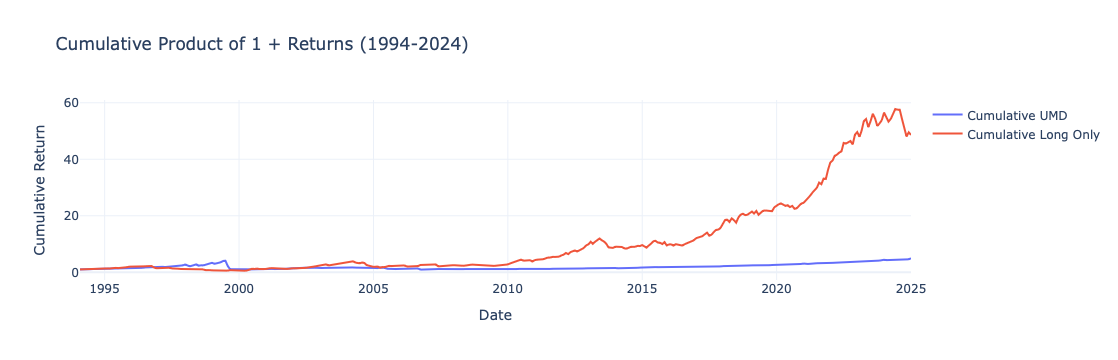

In [69]:
import plotly.graph_objects as go

r_mom_ff['Cumulative UMD'] = (1 + r_mom_ff['UMD']).cumprod()
r_mom_ff['Cumulative Long Only'] = (1 + r_mom_ff['Long Only']).cumprod()

fig = go.Figure()

fig.add_trace(go.Scatter(x=subsample.index, y=r_mom_ff['Cumulative UMD'],
                         mode='lines', name='Cumulative UMD'))

fig.add_trace(go.Scatter(x=subsample.index, y=r_mom_ff['Cumulative Long Only'],
                         mode='lines', name='Cumulative Long Only'))

fig.update_layout(title="Cumulative Product of 1 + Returns (1994-2024)",
                  xaxis_title="Date",
                  yaxis_title="Cumulative Return",
                  template="plotly_white")

fig.show()
